--- Data Preparation ---
Number of rows in merged_df before NaN drop: 37338
Number of rows after dropping NaNs for TMAX_AVG_GS or PREC_GS: 27813
Number of rows dropped: 9525
Year range in the final comparison data: 1951 - 2023
Total data points for scatter plots: 27813


--- Detailed Diagnostics ---

-- Mean of Variables (in the compared dataset) --
Mean temp_gs: 24.48
Mean TMAX_AVG_GS: 24.52
Mean pcpn_gs: 552.19
Mean PREC_GS: 551.71

-- Mean of Differences --
Mean Temperature Difference (temp_gs - TMAX_AVG_GS): -0.0343
Mean Precipitation Difference (pcpn_gs - PREC_GS): 0.4835

-- Descriptive Statistics for Differences --
Temperature Differences:
count    27813.000000
mean        -0.034289
std          0.035978
min         -0.781257
25%         -0.045896
50%         -0.035137
75%         -0.023934
max          0.735416
Name: temp_diff, dtype: float64

Precipitation Differences:
count    27813.000000
mean         0.483498
std          7.027726
min        -90.146000
25%         -0.130000

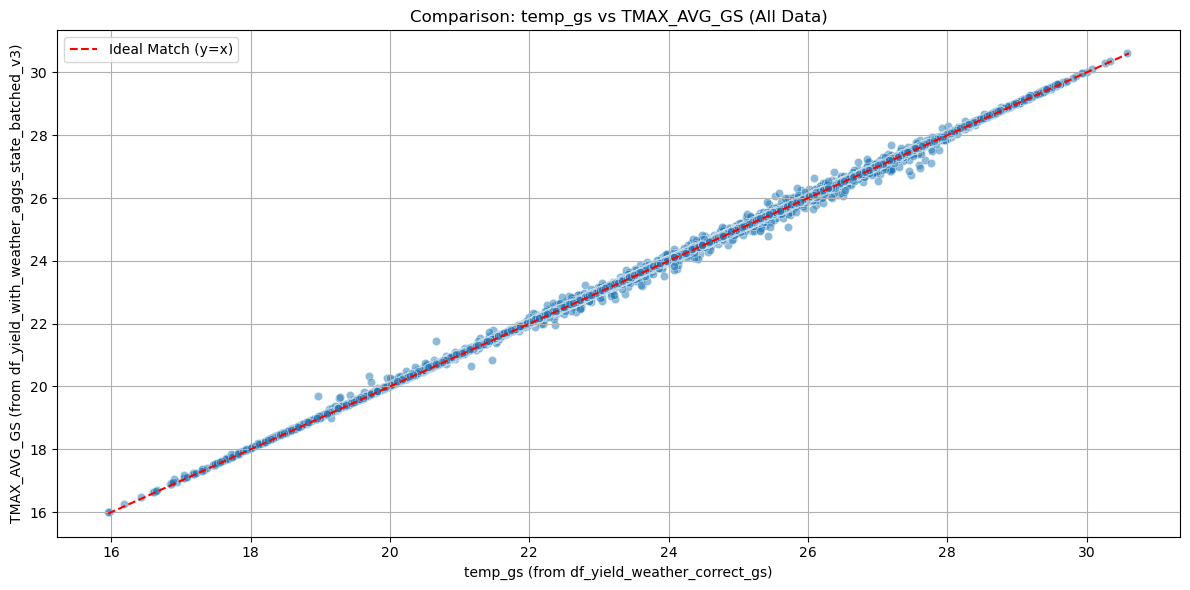

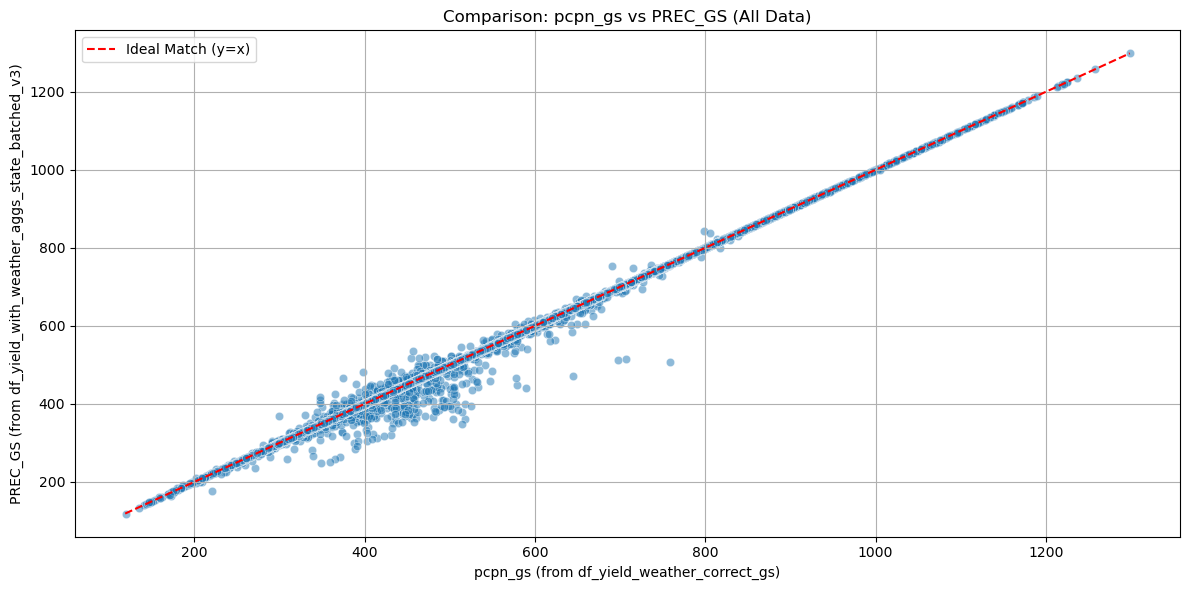

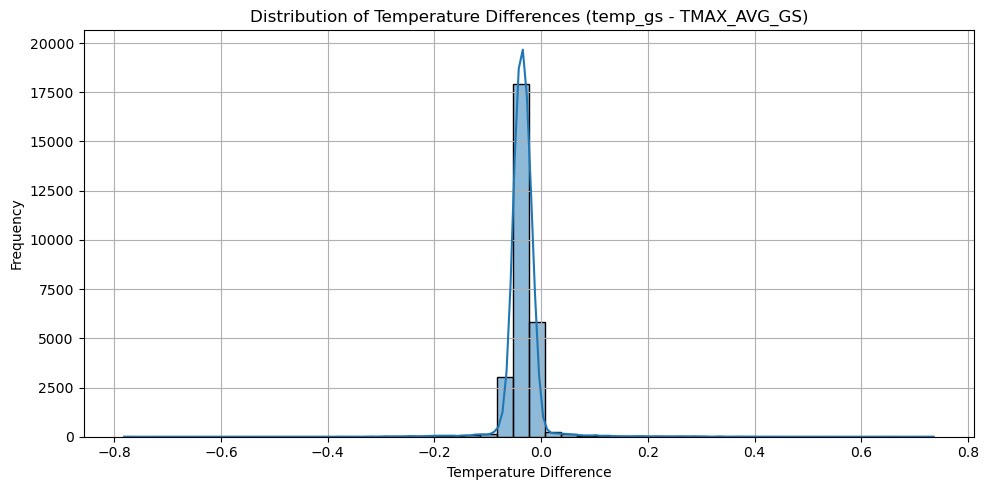

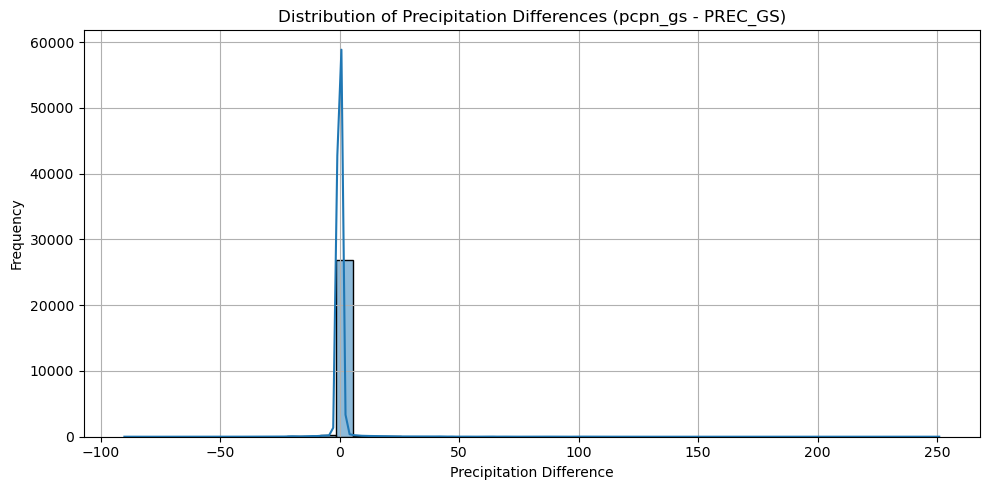


--- Correlation Matrix ---
              temp_gs  TMAX_AVG_GS   pcpn_gs   PREC_GS
temp_gs      1.000000     0.999841 -0.112129 -0.114859
TMAX_AVG_GS  0.999841     1.000000 -0.112951 -0.115656
pcpn_gs     -0.112129    -0.112951  1.000000  0.998886
PREC_GS     -0.114859    -0.115656  0.998886  1.000000


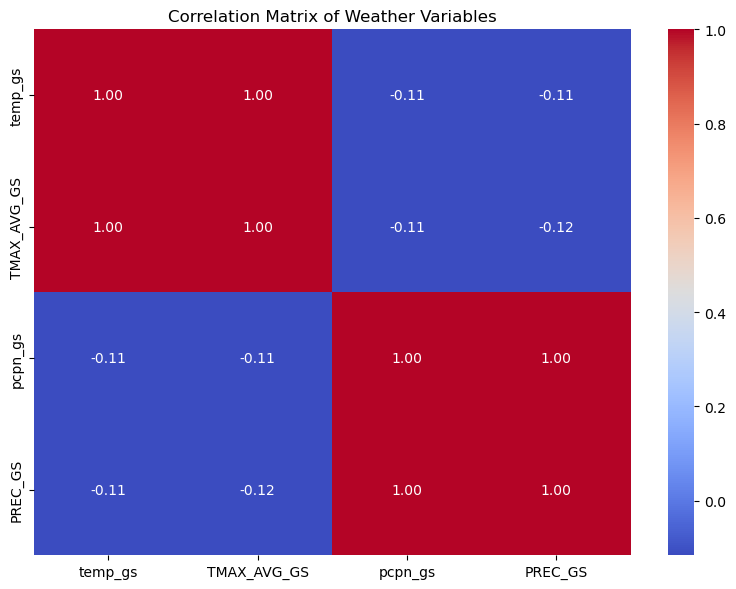

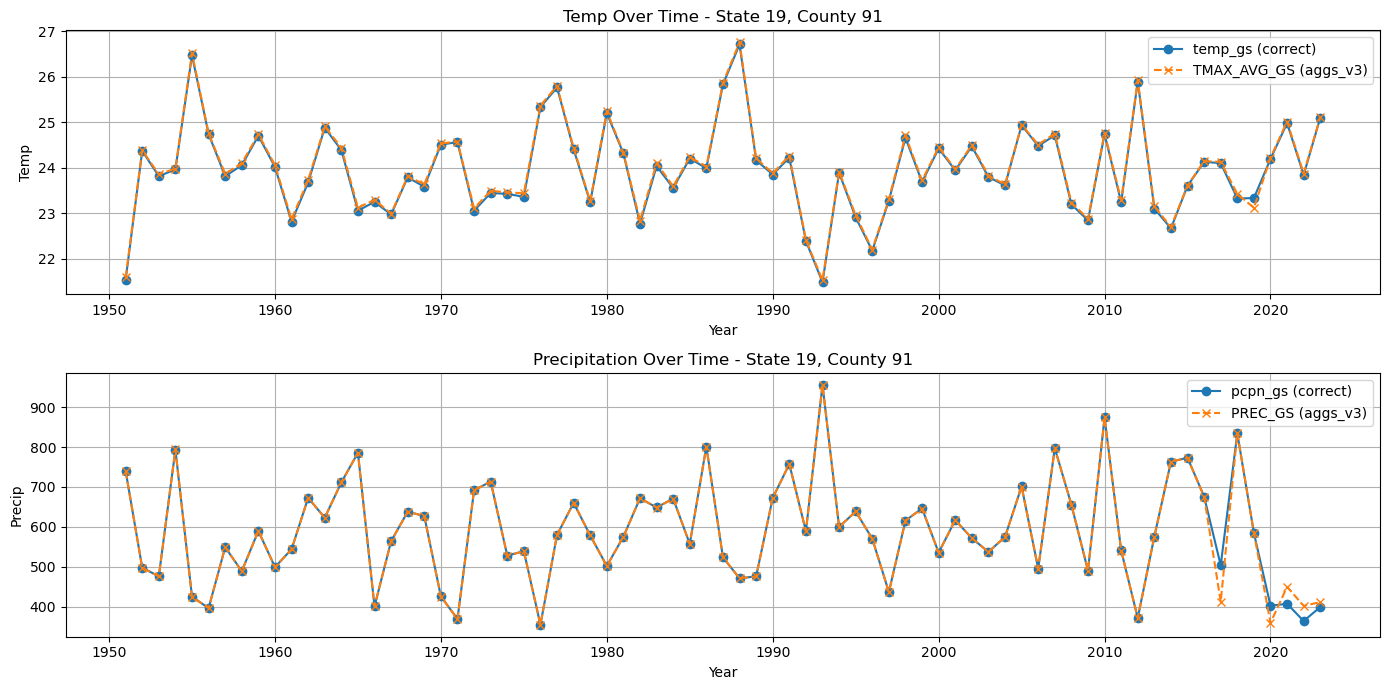


Saved 'weather_comparison_with_differences.csv' with the compared data and calculated differences.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import os

path_climdiv = "../_noaa_climdiv_local/"
path_nclimgrid = "../_noaa_nclimgrid_importer/"

CLIMDIV_CSV_PATH = os.path.join(path_climdiv, "df_yield_climdiv.csv")
CLIMDGRID_CSV_PATH = os.path.join(path_nclimgrid, "df_final_importer.csv")

# --- 1. Load the datasets ---
try:
    df_correct_gs = pd.read_csv(CLIMDIV_CSV_PATH)
    df_aggs_v3 = pd.read_csv(CLIMDGRID_CSV_PATH)
except FileNotFoundError as e:
    print(f"Error loading CSV files: {e}. Please ensure the files are in the correct path.")
    # Exit if files are not found, as further processing is not possible.
    exit()

# --- 2. Select relevant columns and Merge ---
df_correct_select = df_correct_gs[['year', 'state', 'county', 'temp_gs', 'pcpn_gs']].copy()
df_aggs_select = df_aggs_v3[['year', 'state', 'county', 'TMAX_AVG_GS', 'PREC_GS']].copy()

merged_df = pd.merge(df_correct_select, df_aggs_select, on=['year', 'state', 'county'], how='inner')

# --- 3. Handle Missing Values for Comparison ---
original_merged_rows = len(merged_df)
comparison_df = merged_df.dropna(subset=['TMAX_AVG_GS', 'PREC_GS']).copy()
dropped_rows = original_merged_rows - len(comparison_df)

print("--- Data Preparation ---")
print(f"Number of rows in merged_df before NaN drop: {original_merged_rows}")
print(f"Number of rows after dropping NaNs for TMAX_AVG_GS or PREC_GS: {len(comparison_df)}")
print(f"Number of rows dropped: {dropped_rows}")
if not comparison_df.empty:
    print(f"Year range in the final comparison data: {comparison_df['year'].min()} - {comparison_df['year'].max()}")
    print(f"Total data points for scatter plots: {len(comparison_df)}")
else:
    print("Comparison DataFrame is empty. Cannot proceed with diagnostics.")
    exit()


# --- 4. Calculate Differences ---
comparison_df.loc[:, 'temp_diff'] = comparison_df['temp_gs'] - comparison_df['TMAX_AVG_GS']
comparison_df.loc[:, 'pcpn_diff'] = comparison_df['pcpn_gs'] - comparison_df['PREC_GS']
comparison_df.loc[:, 'abs_temp_diff'] = comparison_df['temp_diff'].abs()
comparison_df.loc[:, 'abs_pcpn_diff'] = comparison_df['pcpn_diff'].abs()


# --- 5. Detailed Diagnostics ---
print("\n\n--- Detailed Diagnostics ---")
print("\n-- Mean of Variables (in the compared dataset) --")
print(f"Mean temp_gs: {comparison_df['temp_gs'].mean():.2f}")
print(f"Mean TMAX_AVG_GS: {comparison_df['TMAX_AVG_GS'].mean():.2f}")
print(f"Mean pcpn_gs: {comparison_df['pcpn_gs'].mean():.2f}")
print(f"Mean PREC_GS: {comparison_df['PREC_GS'].mean():.2f}")

print("\n-- Mean of Differences --")
print(f"Mean Temperature Difference (temp_gs - TMAX_AVG_GS): {comparison_df['temp_diff'].mean():.4f}")
print(f"Mean Precipitation Difference (pcpn_gs - PREC_GS): {comparison_df['pcpn_diff'].mean():.4f}")

print("\n-- Descriptive Statistics for Differences --")
print("Temperature Differences:")
print(comparison_df['temp_diff'].describe())
print("\nPrecipitation Differences:")
print(comparison_df['pcpn_diff'].describe())

print("\n-- County with Biggest Mean Absolute Difference --")
county_mean_temp_diff = comparison_df.groupby(['state', 'county'])['abs_temp_diff'].mean().reset_index()
county_max_mean_temp_diff = county_mean_temp_diff.loc[county_mean_temp_diff['abs_temp_diff'].idxmax()]
print(f"County with largest mean absolute temperature difference:")
print(f"  State: {county_max_mean_temp_diff['state']}, County: {county_max_mean_temp_diff['county']}, Mean Abs Diff: {county_max_mean_temp_diff['abs_temp_diff']:.4f}")

county_mean_pcpn_diff = comparison_df.groupby(['state', 'county'])['abs_pcpn_diff'].mean().reset_index()
county_max_mean_pcpn_diff = county_mean_pcpn_diff.loc[county_mean_pcpn_diff['abs_pcpn_diff'].idxmax()]
print(f"\nCounty with largest mean absolute precipitation difference:")
print(f"  State: {county_max_mean_pcpn_diff['state']}, County: {county_max_mean_pcpn_diff['county']}, Mean Abs Diff: {county_max_mean_pcpn_diff['abs_pcpn_diff']:.4f}")

# --- 6. Plotting ---
print("\n\n--- Plotting (Displaying figures) ---")
print("Note: Scatter plots will now use all available data points.")
if len(comparison_df) > 10000: # You have 27813 data points
    print("Warning: Plotting all data points for scatter plots might be slow and result in a dense plot.")

# Plot 1: Temperatures side-by-side (using ALL data)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=comparison_df, x='temp_gs', y='TMAX_AVG_GS', alpha=0.5) # Changed to use full comparison_df
plt.plot([min(comparison_df['temp_gs'].min(), comparison_df['TMAX_AVG_GS'].min()), 
          max(comparison_df['temp_gs'].max(), comparison_df['TMAX_AVG_GS'].max())],
         [min(comparison_df['temp_gs'].min(), comparison_df['TMAX_AVG_GS'].min()),
          max(comparison_df['temp_gs'].max(), comparison_df['TMAX_AVG_GS'].max())],
         color='red', linestyle='--', label='Ideal Match (y=x)')
plt.title('Comparison: temp_gs vs TMAX_AVG_GS (All Data)')
plt.xlabel('temp_gs (from df_yield_weather_correct_gs)')
plt.ylabel('TMAX_AVG_GS (from df_yield_with_weather_aggs_state_batched_v3)')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show() # Changed from savefig to show

# Plot 2: Precipitation side-by-side (using ALL data)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=comparison_df, x='pcpn_gs', y='PREC_GS', alpha=0.5) # Changed to use full comparison_df
plt.plot([min(comparison_df['pcpn_gs'].min(), comparison_df['PREC_GS'].min()), 
          max(comparison_df['pcpn_gs'].max(), comparison_df['PREC_GS'].max())],
         [min(comparison_df['pcpn_gs'].min(), comparison_df['PREC_GS'].min()),
          max(comparison_df['pcpn_gs'].max(), comparison_df['PREC_GS'].max())],
         color='red', linestyle='--', label='Ideal Match (y=x)')
plt.title('Comparison: pcpn_gs vs PREC_GS (All Data)')
plt.xlabel('pcpn_gs (from df_yield_weather_correct_gs)')
plt.ylabel('PREC_GS (from df_yield_with_weather_aggs_state_batched_v3)')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show() # Changed from savefig to show

# Plot 3: Distribution of Temperature Differences
plt.figure(figsize=(10, 5))
sns.histplot(comparison_df['temp_diff'], kde=True, bins=50)
plt.title('Distribution of Temperature Differences (temp_gs - TMAX_AVG_GS)')
plt.xlabel('Temperature Difference'); plt.ylabel('Frequency')
plt.grid(True); plt.tight_layout()
plt.show() # Changed from savefig to show

# Plot 4: Distribution of Precipitation Differences
plt.figure(figsize=(10, 5))
sns.histplot(comparison_df['pcpn_diff'], kde=True, bins=50)
plt.title('Distribution of Precipitation Differences (pcpn_gs - PREC_GS)')
plt.xlabel('Precipitation Difference'); plt.ylabel('Frequency')
plt.grid(True); plt.tight_layout()
plt.show() # Changed from savefig to show

# Correlation Matrix
correlation_matrix = comparison_df[['temp_gs', 'TMAX_AVG_GS', 'pcpn_gs', 'PREC_GS']].corr()
print("\n--- Correlation Matrix ---")
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Weather Variables'); plt.tight_layout()
plt.show() # Changed from savefig to show

# Time series for a sample county
if not comparison_df.empty:
    # Check if there's any data for the default sample state/county after filtering
    sample_state_default = 19 
    sample_county_default = 91
    
    one_location_df = comparison_df[(comparison_df['state'] == sample_state_default) & (comparison_df['county'] == sample_county_default)].sort_values('year')
    
    if one_location_df.empty and not comparison_df.empty: # Fallback if default is not in filtered data
        print(f"\nSample State {sample_state_default} County {sample_county_default} not found in the filtered data for time series plot.")
        print("Attempting to use the first available State/County from the dataset for the time series plot.")
        sample_state_default = comparison_df['state'].iloc[0]
        sample_county_default = comparison_df['county'].iloc[0]
        one_location_df = comparison_df[(comparison_df['state'] == sample_state_default) & (comparison_df['county'] == sample_county_default)].sort_values('year')

    if len(one_location_df) > 1:
        plt.figure(figsize=(14, 7))
        plt.subplot(2, 1, 1)
        plt.plot(one_location_df['year'], one_location_df['temp_gs'], label='temp_gs (correct)', marker='o')
        plt.plot(one_location_df['year'], one_location_df['TMAX_AVG_GS'], label='TMAX_AVG_GS (aggs_v3)', marker='x', linestyle='--')
        plt.title(f'Temp Over Time - State {sample_state_default}, County {sample_county_default}'); plt.xlabel('Year'); plt.ylabel('Temp'); plt.legend(); plt.grid(True)
        plt.subplot(2, 1, 2)
        plt.plot(one_location_df['year'], one_location_df['pcpn_gs'], label='pcpn_gs (correct)', marker='o')
        plt.plot(one_location_df['year'], one_location_df['PREC_GS'], label='PREC_GS (aggs_v3)', marker='x', linestyle='--')
        plt.title(f'Precipitation Over Time - State {sample_state_default}, County {sample_county_default}'); plt.xlabel('Year'); plt.ylabel('Precip'); plt.legend(); plt.grid(True)
        plt.tight_layout()
        plt.show() # Changed from savefig to show
    elif not comparison_df.empty:
        print(f"\nNot enough data points (>1) for a time series plot for State {sample_state_default}, County {sample_county_default} after filtering.")
    # else: comparison_df is empty, already handled

# --- 7. Output the comparison dataframe to CSV ---
# This part is kept as it's useful for the user to have the data.
comparison_df.to_csv("weather_comparison_with_differences.csv", index=False)
print("\nSaved 'weather_comparison_with_differences.csv' with the compared data and calculated differences.")


--- Starting Advanced Difference Diagnostics ---

--- 1. Contextual and Relative Differences ---

Descriptive Statistics for Absolute Percentage Differences:
Temperature Absolute Percentage Difference (%):
count    27813.000000
mean         0.160149
std          0.131952
min          0.000025
25%          0.099321
50%          0.145002
75%          0.193819
max          3.854210
Name: abs_temp_perc_diff, dtype: float64

Precipitation Absolute Percentage Difference (%):
count    27813.000000
mean         0.232301
std          1.619489
min          0.000000
25%          0.011466
50%          0.024958
75%          0.045223
max         39.630210
Name: abs_pcpn_perc_diff, dtype: float64

Number of observations with >10% temp difference: 0 (out of 27813)
Number of observations with >10% pcpn difference: 156 (out of 27813)

--- 2. Statistical Tests for Systematic Differences ---

Paired t-test for Temperature (temp_gs vs. TMAX_AVG_GS):
  Statistic: -158.9436, p-value: 0
  Interpretation: Ther

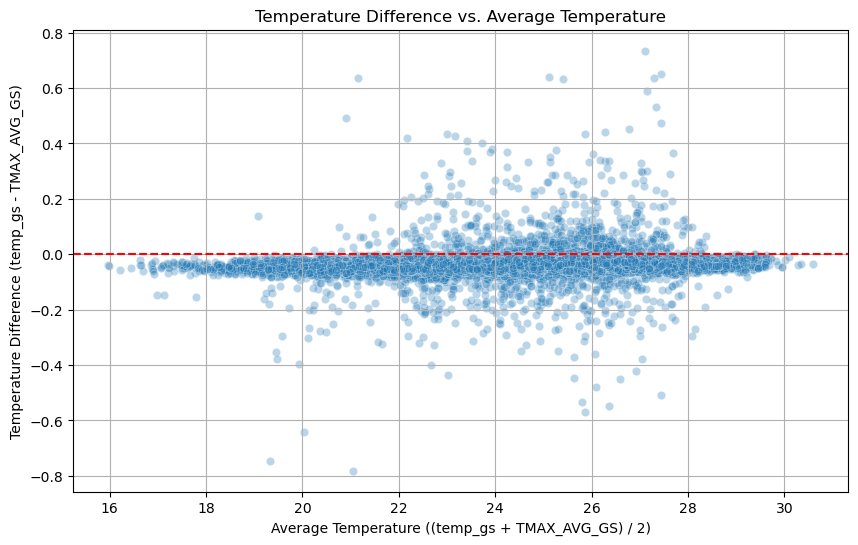

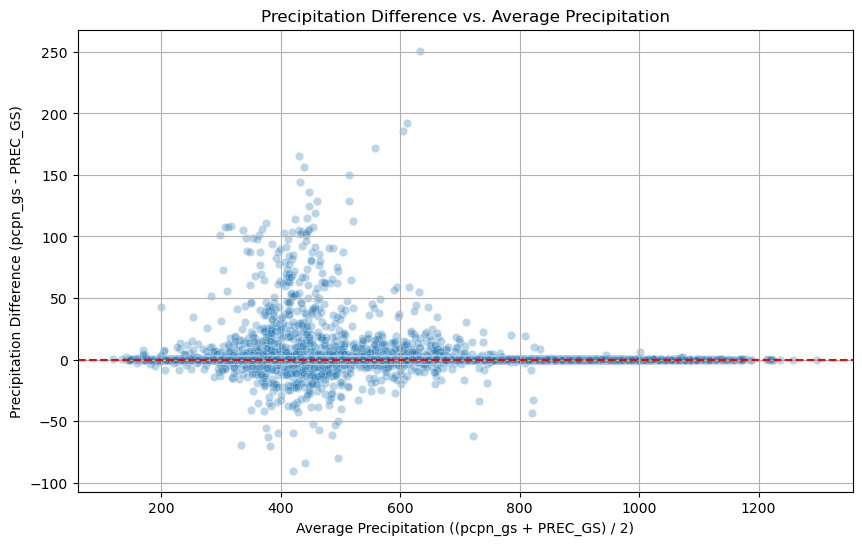

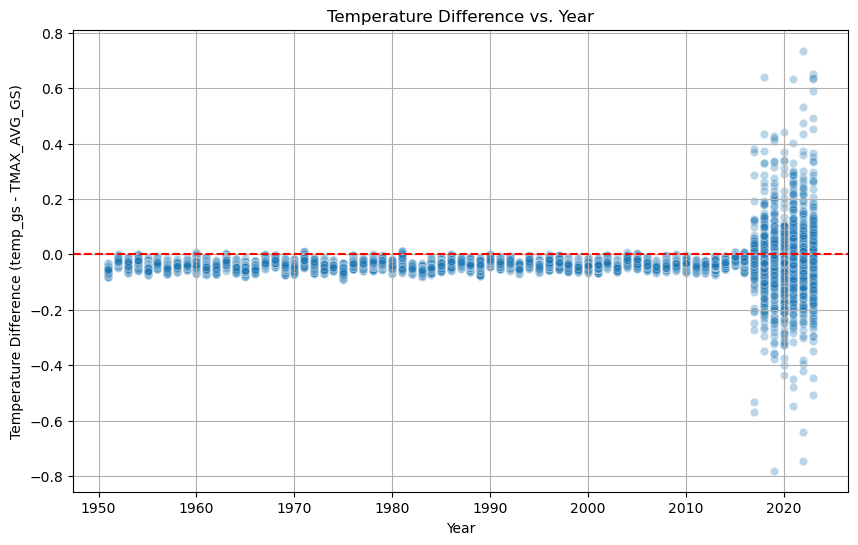

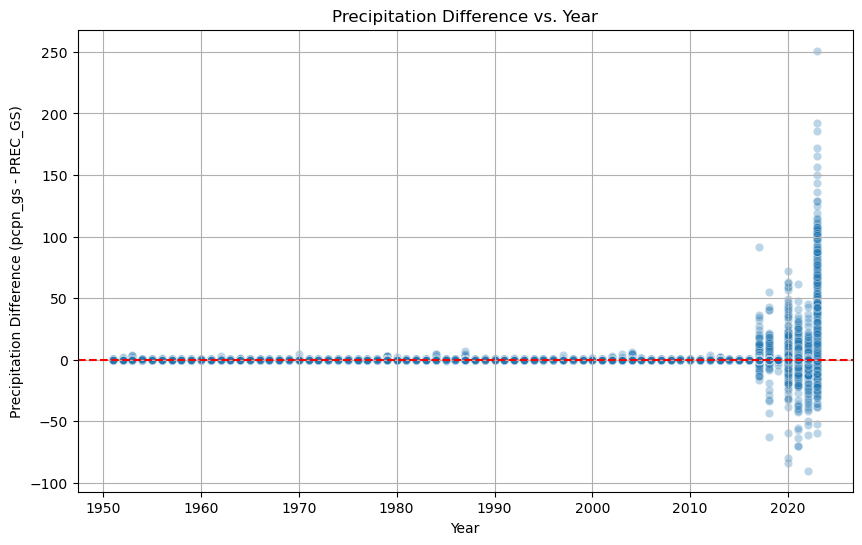


--- 4. Bland-Altman Plots ---


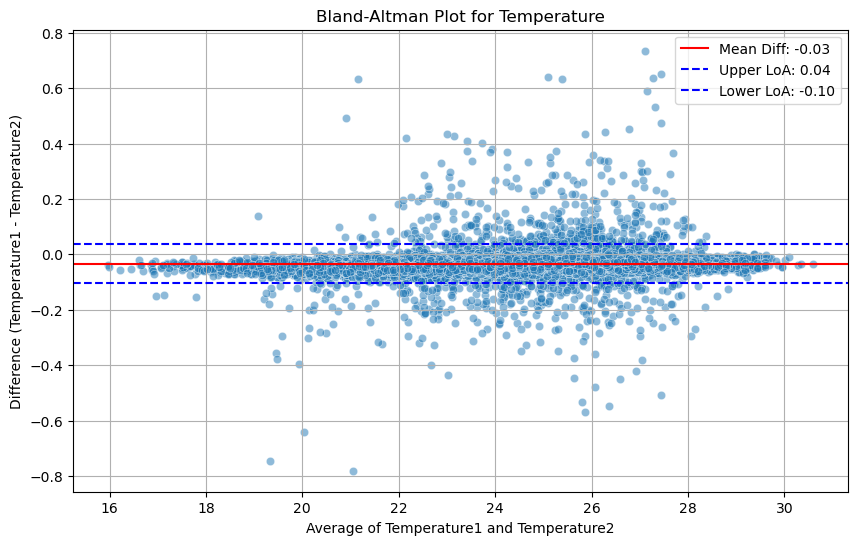

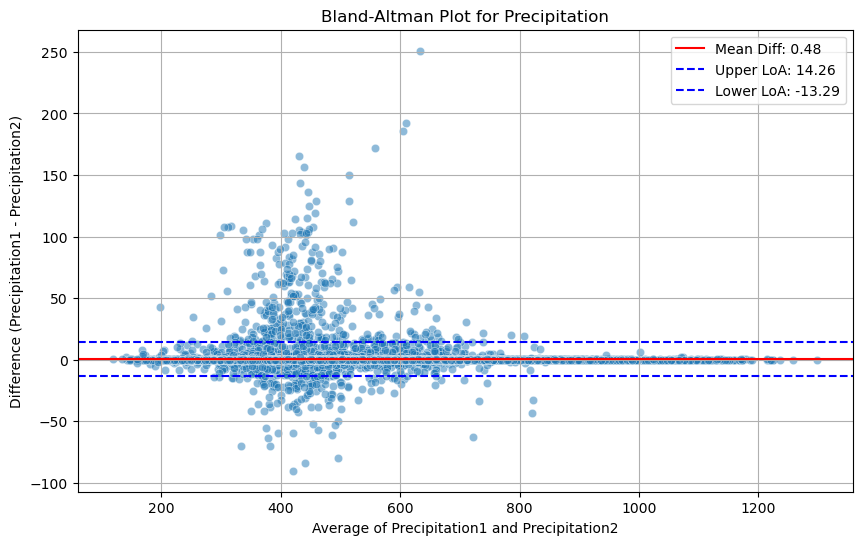


--- 5. Frequency Analysis of Significant Differences ---

Top 10 counties with most frequent significant TEMPERATURE differences (>10%):
   state  county  num_records  sig_temp_years_perc  prop_sig_temp_years
0     17       1           73                    0                  0.0
1     17       3           73                    0                  0.0
2     17       5           73                    0                  0.0
3     17       7           73                    0                  0.0
4     17       9           73                    0                  0.0
5     17      11           73                    0                  0.0
6     17      13           73                    0                  0.0
7     17      15           73                    0                  0.0
8     17      17           73                    0                  0.0
9     17      19           73                    0                  0.0

Top 10 counties with most frequent significant PRECIPITATION differen

In [2]:
# This script assumes 'comparison_df' DataFrame is already loaded and computed
# from a previous cell, containing columns:
# 'year', 'state', 'county', 'temp_gs', 'TMAX_AVG_GS', 'pcpn_gs', 'PREC_GS',
# 'temp_diff', 'pcpn_diff', 'abs_temp_diff', 'abs_pcpn_diff'

print("--- Starting Advanced Difference Diagnostics ---")

if 'comparison_df' not in locals() and 'comparison_df' not in globals():
    print("Error: 'comparison_df' not found. Please ensure the first script/cell has been run successfully.")
    # As a fallback for standalone execution, try to load it (user should ensure path is correct)
    # For a notebook, this part would typically not be needed if cells are run in order.
    try:
        comparison_df = pd.read_csv("weather_comparison_with_differences.csv")
        print("Loaded 'weather_comparison_with_differences.csv' as a fallback.")
        # Recreate necessary columns if they weren't in the CSV (they should be)
        if 'temp_diff' not in comparison_df.columns:
            comparison_df['temp_diff'] = comparison_df['temp_gs'] - comparison_df['TMAX_AVG_GS']
        if 'pcpn_diff' not in comparison_df.columns:
            comparison_df['pcpn_diff'] = comparison_df['pcpn_gs'] - comparison_df['PREC_GS']
        if 'abs_temp_diff' not in comparison_df.columns:
            comparison_df['abs_temp_diff'] = comparison_df['temp_diff'].abs()
        if 'abs_pcpn_diff' not in comparison_df.columns:
            comparison_df['abs_pcpn_diff'] = comparison_df['pcpn_diff'].abs()
    except FileNotFoundError:
        print("Error: Could not load 'weather_comparison_with_differences.csv'. Aborting.")
        exit()
elif comparison_df.empty:
    print("Error: 'comparison_df' is empty. Aborting.")
    exit()

# 1. Refining "Significance" - Contextual and Relative Differences
print("\n--- 1. Contextual and Relative Differences ---")
# Percentage Difference: ((v1 - v2) / ((v1 + v2) / 2)) * 100
# Avoid division by zero if (v1+v2)/2 is zero.
comparison_df['avg_temp_for_perc'] = (comparison_df['temp_gs'] + comparison_df['TMAX_AVG_GS']) / 2
comparison_df['temp_perc_diff'] = np.where(
    comparison_df['avg_temp_for_perc'] == 0, 
    np.nan,  # Or some other placeholder like 0 if appropriate, NaN propagates well
    (comparison_df['temp_diff'] / comparison_df['avg_temp_for_perc']) * 100
)
comparison_df['abs_temp_perc_diff'] = comparison_df['temp_perc_diff'].abs()

comparison_df['avg_pcpn_for_perc'] = (comparison_df['pcpn_gs'] + comparison_df['PREC_GS']) / 2
comparison_df['pcpn_perc_diff'] = np.where(
    comparison_df['avg_pcpn_for_perc'] == 0,
    np.nan,
    (comparison_df['pcpn_diff'] / comparison_df['avg_pcpn_for_perc']) * 100
)
comparison_df['abs_pcpn_perc_diff'] = comparison_df['pcpn_perc_diff'].abs()

print("\nDescriptive Statistics for Absolute Percentage Differences:")
print("Temperature Absolute Percentage Difference (%):")
print(comparison_df['abs_temp_perc_diff'].describe())
print("\nPrecipitation Absolute Percentage Difference (%):")
print(comparison_df['abs_pcpn_perc_diff'].describe())

significant_perc_threshold = 10  # Example: 10%
temp_sig_perc_count = (comparison_df['abs_temp_perc_diff'] > significant_perc_threshold).sum()
pcpn_sig_perc_count = (comparison_df['abs_pcpn_perc_diff'] > significant_perc_threshold).sum()
print(f"\nNumber of observations with >{significant_perc_threshold}% temp difference: {temp_sig_perc_count} (out of {len(comparison_df)})")
print(f"Number of observations with >{significant_perc_threshold}% pcpn difference: {pcpn_sig_perc_count} (out of {len(comparison_df)})")

# 2. Statistical Approaches to Identify Systematic Differences
print("\n--- 2. Statistical Tests for Systematic Differences ---")
# Paired t-test
temp_ttest = stats.ttest_rel(comparison_df['temp_gs'], comparison_df['TMAX_AVG_GS'], nan_policy='omit')
pcpn_ttest = stats.ttest_rel(comparison_df['pcpn_gs'], comparison_df['PREC_GS'], nan_policy='omit')

print(f"\nPaired t-test for Temperature (temp_gs vs. TMAX_AVG_GS):")
print(f"  Statistic: {temp_ttest.statistic:.4f}, p-value: {temp_ttest.pvalue:.4g}")
if temp_ttest.pvalue < 0.05:
    print("  Interpretation: There is a statistically significant mean difference between the two temperature series.")
else:
    print("  Interpretation: There is no statistically significant mean difference between the two temperature series.")

print(f"\nPaired t-test for Precipitation (pcpn_gs vs. PREC_GS):")
print(f"  Statistic: {pcpn_ttest.statistic:.4f}, p-value: {pcpn_ttest.pvalue:.4g}")
if pcpn_ttest.pvalue < 0.05:
    print("  Interpretation: There is a statistically significant mean difference between the two precipitation series.")
else:
    print("  Interpretation: There is no statistically significant mean difference between the two precipitation series.")

# 3. Plotting Differences against Other Variables
print("\n--- 3. Plotting Differences against Other Variables ---")
# Plot temp_diff vs. avg_temp
plt.figure(figsize=(10, 6))
sns.scatterplot(x=comparison_df['avg_temp_for_perc'], y=comparison_df['temp_diff'], alpha=0.3)
plt.title('Temperature Difference vs. Average Temperature')
plt.xlabel('Average Temperature ((temp_gs + TMAX_AVG_GS) / 2)')
plt.ylabel('Temperature Difference (temp_gs - TMAX_AVG_GS)')
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

# Plot pcpn_diff vs. avg_pcpn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=comparison_df['avg_pcpn_for_perc'], y=comparison_df['pcpn_diff'], alpha=0.3)
plt.title('Precipitation Difference vs. Average Precipitation')
plt.xlabel('Average Precipitation ((pcpn_gs + PREC_GS) / 2)')
plt.ylabel('Precipitation Difference (pcpn_gs - PREC_GS)')
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

# Plot temp_diff vs. year
plt.figure(figsize=(10, 6))
sns.scatterplot(x=comparison_df['year'], y=comparison_df['temp_diff'], alpha=0.3)
plt.title('Temperature Difference vs. Year')
plt.xlabel('Year')
plt.ylabel('Temperature Difference (temp_gs - TMAX_AVG_GS)')
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

# Plot pcpn_diff vs. year
plt.figure(figsize=(10, 6))
sns.scatterplot(x=comparison_df['year'], y=comparison_df['pcpn_diff'], alpha=0.3)
plt.title('Precipitation Difference vs. Year')
plt.xlabel('Year')
plt.ylabel('Precipitation Difference (pcpn_gs - PREC_GS)')
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

# 4. Bland-Altman Plots
print("\n--- 4. Bland-Altman Plots ---")
def bland_altman_plot(data1, data2, variable_name="Value"):
    diffs = data1 - data2
    averages = (data1 + data2) / 2
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs, ddof=1) # ddof=1 for sample standard deviation
    upper_loa = mean_diff + 1.96 * std_diff
    lower_loa = mean_diff - 1.96 * std_diff

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=averages, y=diffs, alpha=0.5)
    plt.axhline(mean_diff, color='red', linestyle='-', label=f'Mean Diff: {mean_diff:.2f}')
    plt.axhline(upper_loa, color='blue', linestyle='--', label=f'Upper LoA: {upper_loa:.2f}')
    plt.axhline(lower_loa, color='blue', linestyle='--', label=f'Lower LoA: {lower_loa:.2f}')
    plt.title(f'Bland-Altman Plot for {variable_name}')
    plt.xlabel(f'Average of {variable_name}1 and {variable_name}2')
    plt.ylabel(f'Difference ({variable_name}1 - {variable_name}2)')
    plt.legend()
    plt.grid(True)
    plt.show()

bland_altman_plot(comparison_df['temp_gs'], comparison_df['TMAX_AVG_GS'], "Temperature")
bland_altman_plot(comparison_df['pcpn_gs'], comparison_df['PREC_GS'], "Precipitation")

# 5. Frequency Analysis
print("\n--- 5. Frequency Analysis of Significant Differences ---")
# Using the percentage difference threshold defined earlier (significant_perc_threshold)

comparison_df['is_temp_diff_significant_perc'] = comparison_df['abs_temp_perc_diff'] > significant_perc_threshold
comparison_df['is_pcpn_diff_significant_perc'] = comparison_df['abs_pcpn_perc_diff'] > significant_perc_threshold

county_sig_diff_freq = comparison_df.groupby(['state', 'county']).agg(
    num_records=('year', 'count'), # Total number of comparable years for the county
    sig_temp_years_perc=('is_temp_diff_significant_perc', 'sum'),
    sig_pcpn_years_perc=('is_pcpn_diff_significant_perc', 'sum')
).reset_index()

# Calculate proportion of significant years
county_sig_diff_freq['prop_sig_temp_years'] = county_sig_diff_freq['sig_temp_years_perc'] / county_sig_diff_freq['num_records']
county_sig_diff_freq['prop_sig_pcpn_years'] = county_sig_diff_freq['sig_pcpn_years_perc'] / county_sig_diff_freq['num_records']


N_top_counties = 10
print(f"\nTop {N_top_counties} counties with most frequent significant TEMPERATURE differences (>{significant_perc_threshold}%):")
top_temp_diff_counties = county_sig_diff_freq.sort_values(by=['sig_temp_years_perc', 'prop_sig_temp_years'], ascending=False).head(N_top_counties)
print(top_temp_diff_counties[['state', 'county', 'num_records', 'sig_temp_years_perc', 'prop_sig_temp_years']])

print(f"\nTop {N_top_counties} counties with most frequent significant PRECIPITATION differences (>{significant_perc_threshold}%):")
top_pcpn_diff_counties = county_sig_diff_freq.sort_values(by=['sig_pcpn_years_perc', 'prop_sig_pcpn_years'], ascending=False).head(N_top_counties)
print(top_pcpn_diff_counties[['state', 'county', 'num_records', 'sig_pcpn_years_perc', 'prop_sig_pcpn_years']])

print("\n--- Advanced Difference Diagnostics Complete ---")